# Data Ingestion - Load Large Datasets

In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("ShopEase Data Ingestion") \
    .getOrCreate()

# Load large transactions data from CSV
transactions_df = spark.read.option("header", True) \
                            .csv("/user/student/spark_project/large_transactions.csv")

# Load large inventory data from JSON
inventory_df = spark.read.option("multiline", True) \
                         .json("/user/student/spark_project/large_inventory.json")

# Load large customer feedback data from CSV
feedback_df = spark.read.option("header", True) \
                        .csv("/user/student/spark_project/large_customer_feedback.csv")

# Display a sample of each dataset
print("Transactions Table:")
transactions_df.show(5)

print("Inventory Table:")
inventory_df.show(5)

print("Customer Feedback Table:")
feedback_df.show(5)


Transactions Table:
+--------------+-------+----------+--------+------+----------------+
|transaction_id|user_id|product_id|quantity|amount|transaction_date|
+--------------+-------+----------+--------+------+----------------+
|             1|   5388|      9152|       9|305.67|      2023-01-07|
|             2|  31656|      5763|       1|184.31|      2023-05-16|
|             3|  36725|      4733|       4|  7.66|      2023-01-20|
|             4|  22713|      4207|       1|411.73|      2023-04-19|
|             5|  74067|      1914|       5|499.21|      2023-08-17|
+--------------+-------+----------+--------+------+----------------+
only showing top 5 rows

Inventory Table:
+------+----------+------------+-----------+
| price|product_id|product_name|stock_level|
+------+----------+------------+-----------+
| 91.89|         1|   Product_1|         61|
|  9.75|         2|   Product_2|        553|
|182.89|         3|   Product_3|        328|
|148.38|         4|   Product_4|        347|
| 

# Data Cleaning and Transformation with RDDs

In [2]:
from pyspark.sql import Row
import hashlib

# Convert transactions DataFrame to RDD
transactions_rdd = transactions_df.rdd

# Filter out corrupted records (e.g., missing transaction_id or amount)
# Assuming 'transaction_id' and 'amount' are the required fields
cleaned_rdd = transactions_rdd.filter(lambda row: row['transaction_id'] is not None or row['amount'] is not None)

# Function to Anonymize user IDs using Hashing
def anonymize(record):
    # Assuming 'user_id' is the field we want to anonymize
    hashed_user_id = hashlib.sha256(record['user_id'].encode()).hexdigest()
    # Create a new Row object with the hashed user_id
    new_record = record.asDict()  # Convert Row to dict
    new_record['user_id'] = hashed_user_id  # Replace the user_id with the hashed value
    return Row(**new_record)  # Return a new Row object with the updated user_id

# Apply the anonymization function to the RDD
anonymized_rdd = cleaned_rdd.map(anonymize)

# Convert back to DataFrame
cleaned_transactions_df = anonymized_rdd.toDF()

# Display cleaned and anonymized data
print("Cleaned and Anonymized Transactions Data:")
cleaned_transactions_df.show(5)

cleaned_transactions_df.count()

Cleaned and Anonymized Transactions Data:
+--------------+--------------------+----------+--------+------+----------------+
|transaction_id|             user_id|product_id|quantity|amount|transaction_date|
+--------------+--------------------+----------+--------+------+----------------+
|             1|b797d397acb6b79e3...|      9152|       9|305.67|      2023-01-07|
|             2|3911f43de537d6765...|      5763|       1|184.31|      2023-05-16|
|             3|a0127a90205f9ca56...|      4733|       4|  7.66|      2023-01-20|
|             4|3ec95a5c41362c498...|      4207|       1|411.73|      2023-04-19|
|             5|90ee0ca050e4b8892...|      1914|       5|499.21|      2023-08-17|
+--------------+--------------------+----------+--------+------+----------------+
only showing top 5 rows



1000000

# DataFrame Operations for Cleaning and Transformation

In [3]:
from pyspark.sql.functions import col, lower, trim

# Step 3: DataFrame Operations for Cleaning and Transformation

# Clean inventory data by handling missing values and normalizing text
cleaned_inventory_df = inventory_df.dropna(subset=["stock_level"]) \
                                   .withColumn("product_name", lower(trim(col("product_name"))))

# Display the cleaned inventory data (first 5 rows)
print("Cleaned Inventory Data:")
cleaned_inventory_df.show(5)

# Assuming you have a column in both DataFrames for joining (e.g., 'product_id')
# Perform a join operation to combine user activity logs with cleaned transaction data
# For this example, we'll assume joining on 'product_id' from inventory and 'product_id' from transactions
joined_df = cleaned_inventory_df.join(transactions_df, "product_id", "inner")

# Display the joined DataFrame (first 5 rows)
print("Joined Data:")
joined_df.show(5)


Cleaned Inventory Data:
+------+----------+------------+-----------+
| price|product_id|product_name|stock_level|
+------+----------+------------+-----------+
| 91.89|         1|   product_1|         61|
|  9.75|         2|   product_2|        553|
|182.89|         3|   product_3|        328|
|148.38|         4|   product_4|        347|
| 78.17|         5|   product_5|        180|
+------+----------+------------+-----------+
only showing top 5 rows

Joined Data:
+----------+-----+------------+-----------+--------------+-------+--------+------+----------------+
|product_id|price|product_name|stock_level|transaction_id|user_id|quantity|amount|transaction_date|
+----------+-----+------------+-----------+--------------+-------+--------+------+----------------+
|      9152|238.7|product_9152|        871|             1|   5388|       9|305.67|      2023-01-07|
|      5763|91.52|product_5763|        252|             2|  31656|       1|184.31|      2023-05-16|
|      4733|33.22|product_4733|  

# Spark SQL Queries

## Create Temporary Views for SQL Queries

In [4]:
cleaned_transactions_df.createOrReplaceTempView("transactions")
cleaned_inventory_df.createOrReplaceTempView("inventory")
joined_df.createOrReplaceTempView("joined_data")


## Top 10 Most Purchased Products in the Last Month

In [5]:
top_products_df = spark.sql("""
    SELECT product_id, COUNT(*) AS purchase_count
    FROM transactions
    WHERE transaction_date >= '2023-12-01' and transaction_date <= '2023-12-30'
    GROUP BY product_id
    ORDER BY purchase_count DESC
    LIMIT 10
""")
print("Top 10 Most Purchased Products in the Last Month:")
top_products_df.show()

Top 10 Most Purchased Products in the Last Month:


+----------+--------------+
|product_id|purchase_count|
+----------+--------------+
|       629|            22|
|      4590|            21|
|      7350|            20|
|      8334|            20|
|       127|            20|
|      4870|            19|
|      1733|            19|
|      3673|            19|
|      8220|            19|
|      6795|            19|
+----------+--------------+



## Query: Monthly revenue trends

In [6]:
monthly_revenue_df = spark.sql("""
    SELECT 
        YEAR(transaction_date) AS year, 
        MONTH(transaction_date) AS month, 
        SUM(amount) AS total_revenue
    FROM transactions  
    GROUP BY year, month
    ORDER BY year, month
""")
print("Monthly Revenue Trends:")
monthly_revenue_df.show()

Monthly Revenue Trends:


+----+-----+--------------------+
|year|month|       total_revenue|
+----+-----+--------------------+
|2023|    1| 2.144845023000001E7|
|2023|    2| 1.949427259999998E7|
|2023|    3|        2.15441875E7|
|2023|    4| 2.081824269000004E7|
|2023|    5|2.1434179750000037E7|
|2023|    6|2.0885249160000004E7|
|2023|    7|2.1363113009999946E7|
|2023|    8|2.1311435569999993E7|
|2023|    9| 2.066753037999999E7|
|2023|   10|2.1576082419999994E7|
|2023|   11| 2.090389989999999E7|
|2023|   12| 2.084169785999999E7|
+----+-----+--------------------+



## Query: Inventory turnover rates


In [7]:
turnover_rate_df = spark.sql("""
    SELECT 
        i.product_id, 
        i.product_name, 
        SUM(t.amount) AS total_sold,
        AVG(i.stock_level) AS avg_stock_level,
        (SUM(t.amount) / AVG(i.stock_level)) AS turnover_rate
    FROM inventory i 
    JOIN transactions t ON i.product_id = t.product_id 
    GROUP BY i.product_id, i.product_name
    ORDER BY turnover_rate DESC
""")
print("Inventory Turnover Rates:")
turnover_rate_df.show()

Inventory Turnover Rates:


+----------+------------+------------------+---------------+------------------+
|product_id|product_name|        total_sold|avg_stock_level|     turnover_rate|
+----------+------------+------------------+---------------+------------------+
|      7567|product_7567|30000.179999999997|            1.0|30000.179999999997|
|      2871|product_2871|29058.729999999996|            1.0|29058.729999999996|
|      9501|product_9501|          28807.18|            1.0|          28807.18|
|      4373|product_4373|27230.920000000002|            1.0|27230.920000000002|
|      7759|product_7759|26989.679999999997|            1.0|26989.679999999997|
|      1284|product_1284|          26472.62|            1.0|          26472.62|
|      3135|product_3135|24224.690000000002|            1.0|24224.690000000002|
|      1467|product_1467|24153.539999999997|            1.0|24153.539999999997|
|        40|  product_40|          22390.04|            1.0|          22390.04|
|      2821|product_2821|          21368

# Top Products Bar Chart

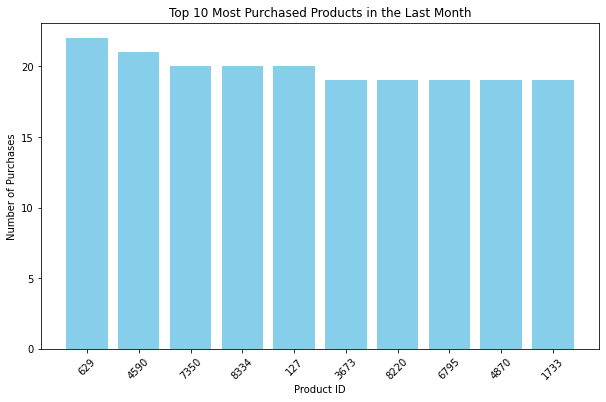

In [12]:
import matplotlib.pyplot as plt

# Convert top products Spark DataFrame to Pandas for plotting
top_products_pandas = top_products_df.toPandas()

# Plotting a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_products_pandas['product_id'], top_products_pandas['purchase_count'], color='skyblue')
plt.title('Top 10 Most Purchased Products in the Last Month')
plt.xlabel('Product ID')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.show()


# Revenue Trend Line Chart

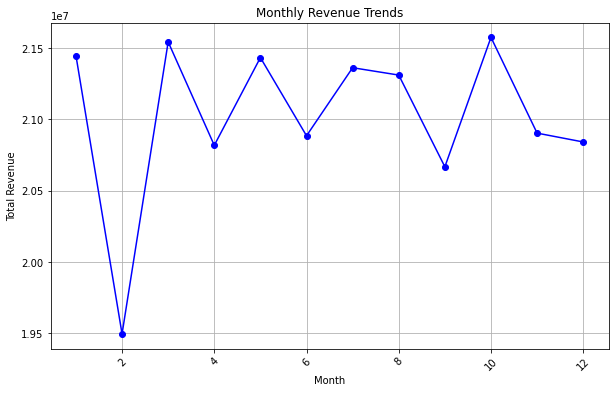

In [13]:
# Convert monthly revenue Spark DataFrame to Pandas for plotting
monthly_revenue_pandas = monthly_revenue_df.toPandas()

# Plotting a line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_pandas['month'], monthly_revenue_pandas['total_revenue'], marker='o', color='b')
plt.title('Monthly Revenue Trends')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Inventory Turnover Heatmap

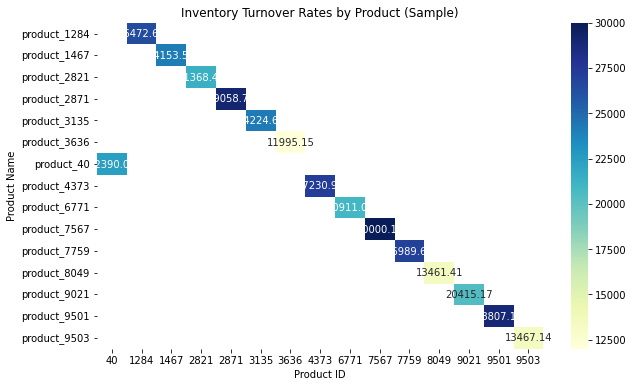

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Limit the rows to a manageable size (e.g., 100 rows)
turnover_rate_sample = turnover_rate_df.limit(15)

# Convert the limited Spark DataFrame to Pandas
turnover_rate_pandas = turnover_rate_sample.toPandas()

# Plotting a heatmap of turnover rates from the sample
plt.figure(figsize=(10, 6))
sns.heatmap(turnover_rate_pandas.pivot("product_name", "product_id", "turnover_rate"), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Inventory Turnover Rates by Product (Sample)')
plt.xlabel('Product ID')
plt.ylabel('Product Name')
plt.show()


# Store Data into HDFS

In [8]:

output_path_hdfs = "hdfs:///user/student/spark_project/batch_data"

# Save the cleaned transactions data to HDFS in Parquet format
cleaned_transactions_df.write \
    .mode("overwrite") \
    .parquet(f"{output_path_hdfs}/transactions_parquet")

# Save the cleaned inventory data to HDFS
cleaned_inventory_df.write \
    .mode("overwrite") \
    .parquet(f"{output_path_hdfs}/inventory_parquet")

# Save the joined data to HDFS
joined_df.write \
    .mode("overwrite") \
    .parquet(f"{output_path_hdfs}/joined_data_parquet")